Import needed libraries

In [ ]:
import os
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


## Create needed functions

Define a function to show example training images

In [ ]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()


Define a function to plot the training and validation data

In [ ]:
def tr_plot(tr_data, start_epoch):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range (start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)     # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')
    sc_label='best epoch= ' + str(index_loss + 1 +start_epoch)
    vc_label='best epoch= ' + str(index_acc + 1 + start_epoch)

    fig,axes=plt.subplots(nrows= 1, ncols= 2, figsize= (20, 8))
    axes[0].plot(Epochs,tloss, 'r', label= 'Training loss')
    axes[0].plot(Epochs,vloss, 'g', label= 'Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s= 150, c= 'blue', label= sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc, 'r', label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc, 'g', label= 'Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s= 150, c= 'blue', label= vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

define a function to create confusion matrix and classification report

In [ ]:
def print_info(test_gen, preds, save_dir, subject ):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []

    for key, value in class_dict.items():
        new_dict[value] = key             # dictionary {integer of class number: string of class name}

    # store new_dict as a text file in the save_dir
    classes = list(new_dict.values())     # list of string of class names
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)

    if errors > 0:
        plot_bar = []
        plot_class = []
        for  key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')

        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
            plt.title(' Errors by Class on Test Set')

    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
        plt.figure(figsize= (fig_width, fig_height))
        sns.heatmap(cm, annot= True, vmin= 0, fmt= 'g', cmap= 'Blues', cbar= False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation= 90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation= 0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names= classes)
    print("Classification Report:\n----------------------\n", clr)

define a function to save the model

In [ ]:
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):    
    # save the model
    save_id = str(model_name +  '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print('model was saved as ' + model_save_loc) 

    # create the class_df and convert to csv file    
    class_dict = generator.class_indices 
    height = []
    width = []
    scale = []
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)

    Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
    Class_series = pd.Series(list(class_dict.keys()), name= 'class') 
    Height_series = pd.Series(height, name= 'height')
    Width_series = pd.Series(width, name= 'width')
    Scale_series = pd.Series(scale, name= 'scale by')
    class_df = pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis= 1)    
    csv_name = 'class_dict.csv'
    csv_save_loc = os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index= False) 
    print('class csv file was saved as ' + csv_save_loc) 
    return model_save_loc, csv_save_loc

Define a class for custom callback

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience 		# specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience 	# specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold 		# specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor 			# factor by which to reduce the learning rate
        self.dwell = dwell
        self.batches = batches 			# number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch 	# save this value to restore if restarting training
        self.count = 0 				# how many times lr has been reduced without improvement
        self.stop_count = 0			# how many times lr has been adjusted with no improvement
        self.best_epoch = 1   			# epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 		# set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf 		# set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() 	  # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        if self.base_model != None:
            msg = 'initializing callback and starting training with base_model trainable'
        else:
            msg = 'initializing callback and starting training'
        print(msg)

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    # Define a function that will run after training
    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg = f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print(msg)

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

    # Define a function of batches that will run during the epoch
    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100  # get training accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    # Define a function which define the time of epoch starting
    def on_epoch_begin(self, epoch, logs= None):
        self.now = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        later = time.time()
        duration = later - self.now

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss

                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg = 'enter H to halt training, F to fine tune model, or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans == 'f':
                        if base_model.trainable:
                            msg = 'base_model is already set as trainable'
                        else:
                            msg = 'setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable = True
                        print(msg)
                        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg)
                        self.count = 0
                        self.stop_count = 0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial
                    else:
                        ans = int(ans)
                        self.ask_epoch += ans
                        msg = f' training will continue until epoch ' + str(self.ask_epoch)
                        print(msg)
                        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                        print(msg)

Define function to create dataframe

In [ ]:
def preprocess(sdir, trsplit, vsplit):
    filepaths = []
    labels = []    
    folds = os.listdir(sdir)
    for fold in folds:
        foldpath = os.path.join(sdir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
	          

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    dsplit = vsplit / (1 - trsplit)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= trsplit, shuffle= True, random_state= 123, stratify= strat)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= dsplit, shuffle= True, random_state= 123, stratify= strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))

    # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount = len(train_df['labels'].unique())
    tecount = len(test_df['labels'].unique())
    vcount = len(valid_df['labels'].unique())
    if trcount < tecount :
        msg = '** WARNING ** number of classes in training set is less than the number of classes in test set'
        print(msg)
        msg = 'This will throw an error in either model.evaluate or model.predict'
        print(msg)
    if trcount != vcount:
        msg = '** WARNING ** number of classes in training set not equal to number of classes in validation set'
        print(msg)
        msg = ' this will throw an error in model.fit'
        print(msg)
        print('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount)
        ans = input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print('Halting Execution')
            import sys
            sys.exit('program halted by user')
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df

## Create model

Define location and spliting data

In [ ]:
sdir = r'/content/Training'
trsplit = 0.9
vsplit = 0.05
train_df, test_df, valid_df= preprocess(sdir, trsplit, vsplit)

train_df length:  2583   test_df length:  144   valid_df length:  143
[744, 743, 740, 356]


Create Train, Valid, and Test generators

In [ ]:
img_size = (224, 224)
channels = 3
batch_size = 40
img_shape = (img_size[0], img_size[1], channels)
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80],reverse=True)[0]  
test_steps = int(length/test_batch_size)
print(f'test batch size: {test_batch_size}   -   test steps: {test_steps}')

def scalar(img):    
    return img 


trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

msg = '{:70s} for the train generator'.format(' ')
print(msg, '\r', end='') 
train_gen=trgen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

msg = '{:70s} for the test generator'.format(' ')
print(msg, '\r', end='') 
test_gen = tvgen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

msg = '{:70s} for the valid generator'.format(' ')
print(msg, '\r', end='')
valid_gen = tvgen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

classes = list(train_gen.class_indices.keys())
class_count = len(classes)  	# to define classes in dense layer
train_steps = int(np.ceil(len(train_gen.labels) / batch_size))
labels = test_gen.labels

test batch size: 72   -   test steps: 2
Found 2583 validated image filenames belonging to 4 classes.
Found 144 validated image filenames belonging to 4 classes.
Found 143 validated image filenames belonging to 4 classes.


Display some training images

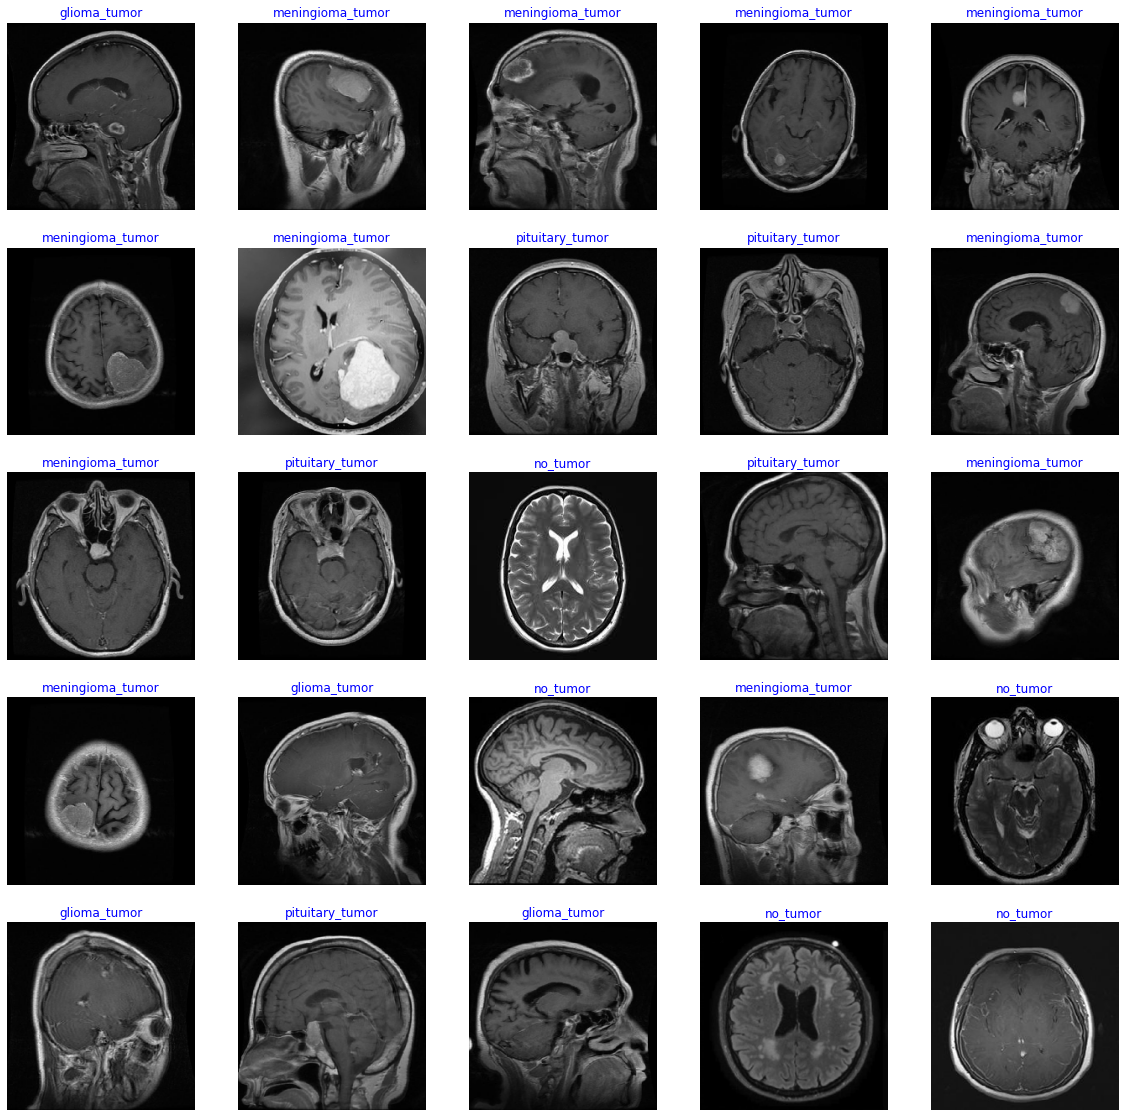

In [ ]:
show_image_samples(train_gen)

Define model structure

In [ ]:
img_size = (224, 224)
channels = 3
batch_size = 40
img_shape = (img_size[0], img_size[1], channels)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_______________________________________

Instantiate the Custom Callback and train the model

In [ ]:
epochs = 40
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
dwell = True 		# experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = train_steps
callbacks = [MyCallback(model= model, base_model= base_model, patience= patience, stop_patience= stop_patience, threshold= threshold,
                   factor= factor,dwell= dwell, batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]


Fitting the model

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks, validation_data= valid_gen,
               validation_steps= None, shuffle= False, initial_epoch= 0)

initializing callback and starting training with base_model trainable
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     7.553   79.172   7.24442  65.734   0.00100  0.00100  accuracy     0.00    80.92  
 2 /40     5.604   93.380   5.10858  91.608   0.00100  0.00100  val_loss    29.48    47.88  
 3 /40     4.349   96.671   4.03093  91.608   0.00100  0.00100  val_loss    21.09    48.61  
 4 /40     3.435   97.677   3.25911  90.909   0.00100  0.00100  val_loss    19.15    48.81  
 5 /40     2.734   98.722   2.58784  93.007   0.00100  0.00100  val_loss    20.60    48.06  
enter H to halt training or an integer for number of epochs to run then ask again
10
 training will continue until epoch 15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     2.196   98.877   2.12176  93.706   0.00100  0.00100  val_loss    18.01    48.80  
 7 /40     1.771   99.264   1.71009  93.706   0.00100  0.00100  val_loss    19.40    48.05  
 8 /40     1.440   99.071   1.39137  95.105   0.00100  0.00100  val_loss    18.64    48.66  
 9 /40     1.157   99.613   1.09662  96.

Plotting history

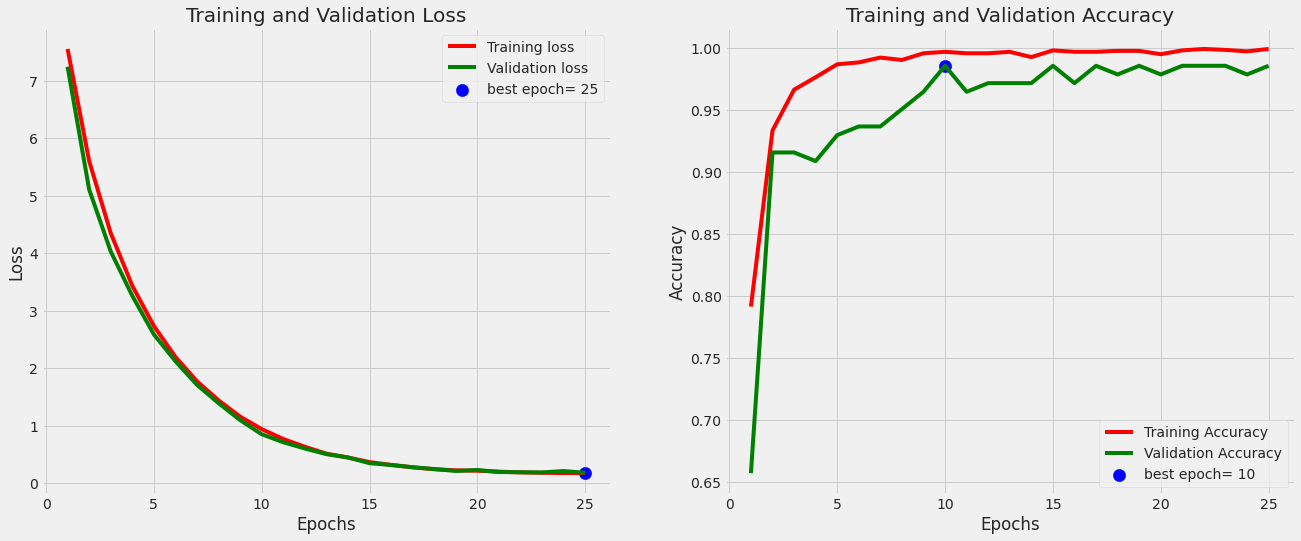

In [ ]:
tr_plot(history, 0)

Model Evaluation

In [ ]:
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 2s 242ms/step - loss: 0.2085 - accuracy: 0.9792
Train Loss:  0.15155799686908722
Train Accuracy:  1.0
--------------------
Validation Loss:  0.15304048359394073
Validation Accuracy:  1.0
--------------------
Test Loss:  0.20850703120231628
Test Accuracy:  0.9791666865348816


Making Predection on test set

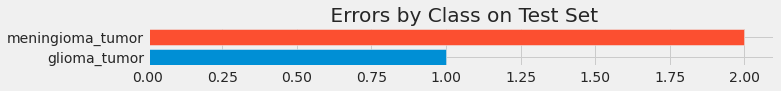

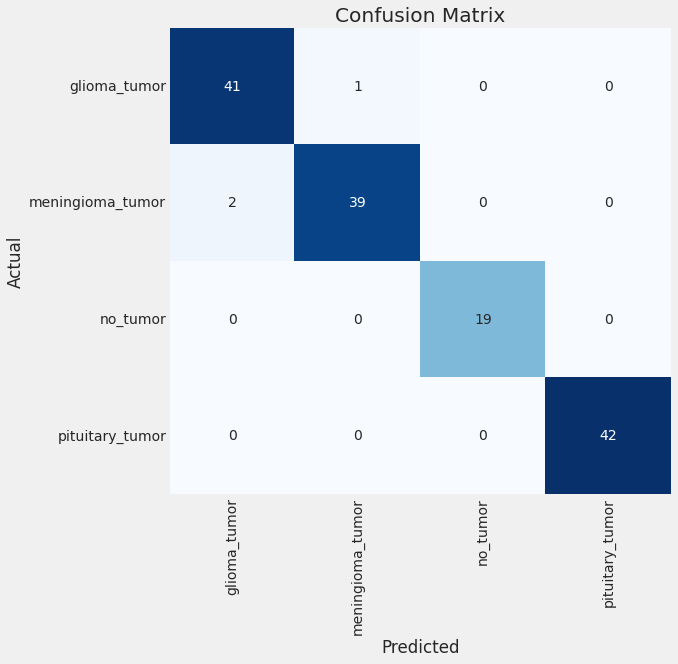

Classification Report:
----------------------
                   precision    recall  f1-score   support

    glioma_tumor       0.95      0.98      0.96        42
meningioma_tumor       0.97      0.95      0.96        41
        no_tumor       1.00      1.00      1.00        19
 pituitary_tumor       1.00      1.00      1.00        42

        accuracy                           0.98       144
       macro avg       0.98      0.98      0.98       144
    weighted avg       0.98      0.98      0.98       144



In [ ]:
working_dir = '/content/Training'
subject = 'Brain Tumors' #title
preds = model.predict(test_gen)
acc = print_info(test_gen, preds, working_dir, subject)

Saving model

In [ ]:
model_name = 'EfficientNetB3'
model_save_loc, csv_save_loc = saver(working_dir, model, model_name, subject, acc, img_size, 1,  train_gen)

model was saved as /content/Training/EfficientNetB3-Brain Tumors-No.h5
class csv file was saved as /content/Training/class_dict.csv
